<a href="https://colab.research.google.com/github/AlexandreLarget/tensorflow_projects/blob/main/Image_classification_Eurosat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eurosat avec transfer learning

In [ ]:
!nvidia-smi -L

## Get and visualize the data

In [79]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow import keras

In [80]:
data, info = tfds.load("Eurosat", split="train", shuffle_files=True, as_supervised=True, with_info=True)

In [81]:
class_names = info.features['label'].names
class_names

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [82]:
def show_image(data):
  random_data = data.shuffle(buffer_size=int(len(data)/1000))
  sample = random_data.take(1)

  for image, label in sample:
    print(f"Image shape: {image.shape}")
    print(f"Image type: {image.dtype}")
    print(f"Label num: {label}")
    print(f"Label classe: {class_names[label]}")
    print(f"Minimum value: {tf.reduce_min(image).numpy()}")
    print(f"Maximum value: {tf.reduce_max(image).numpy()}")
    plt.imshow(image)
    plt.axis(False)

Image shape: (64, 64, 3)
Image type: <dtype: 'uint8'>
Label num: 7
Label classe: Residential
Minimum value: 67
Maximum value: 255


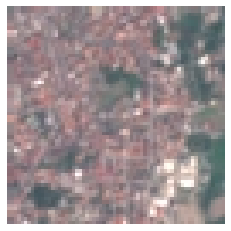

In [83]:
show_image(data)

In [84]:
len(data)

27000

In [85]:
split = int(len(data) * 0.8)
train_data = data.take(split)
test_data = data.skip(split)

In [86]:
len(train_data), len(test_data)

(21600, 5400)

In [87]:
train_data

<TakeDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

## Data preprocessing

In [88]:
def preprocessing_image(image, label, img_size=224):
  image = tf.image.resize(image, [img_size, img_size])
  image = 2 * (image / 255) - 1 # Normalize between [-1 ; 1]
  return tf.cast(image, tf.float32), label

In [89]:
train_data = train_data.map(preprocessing_image, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(preprocessing_image, num_parallel_calls=tf.data.AUTOTUNE)

In [90]:
train_data = train_data.batch(32).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [91]:
len(train_data), 32*len(train_data)

(675, 21600)

## Transfer learning

In [92]:
vit_16_transf = "https://tfhub.dev/sayakpaul/vit_s16_classification/1"

In [93]:
import tensorflow_hub as hub
from tensorflow.keras import layers

In [94]:
transf_layer = hub.KerasLayer(vit_16_transf,
                              trainable=False,
                              input_shape=(224, 224, 3), 
                              name="transfer_layer")

## Model: transformer vit 16

In [95]:
model_euro = tf.keras.Sequential([
    transf_layer,
    layers.Dense(128, activation="relu", name="dense"),
    layers.Dense(len(class_names), activation="softmax", name="output")
], name="model_euro")

In [96]:
model_euro.compile(loss="sparse_categorical_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])

In [97]:
model_euro.summary()

Model: "model_euro"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transfer_layer (KerasLayer)  (None, 1000)             22050664  
                                                                 
 dense (Dense)               (None, 128)               128128    
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total params: 22,180,082
Trainable params: 129,418
Non-trainable params: 22,050,664
_________________________________________________________________


In [98]:
model_euro_history = model_euro.fit(train_data,
                                    epochs=2,
                                    validation_data=test_data)

Epoch 1/2
675/675 [==============================] - 100s 142ms/step - loss: 0.3650 - accuracy: 0.8795 - val_loss: 0.2420 - val_accuracy: 0.9209
Epoch 2/2
675/675 [==============================] - 93s 138ms/step - loss: 0.2056 - accuracy: 0.9298 - val_loss: 0.2001 - val_accuracy: 0.9348


## Model: EfficientNet

In [128]:
transfer = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(include_top=False)

In [129]:
transfer.trainable = False

In [133]:
inputs = layers.Input(shape=(224, 224, 3))
x = transfer(inputs)
x = layers.GlobalAvgPool2D()(x)
output = layers.Dense(len(class_names), activation="softmax")(x)

model_euro_2 = tf.keras.Model(inputs, output)

In [134]:
model_euro_2.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                     metrics=["accuracy"])

In [135]:
model_euro_2_history = model_euro_2.fit(train_data,
                                        epochs=3,
                                        validation_data=test_data)

Epoch 1/3
675/675 [==============================] - 92s 123ms/step - loss: 2.2636 - accuracy: 0.1853 - val_loss: 2.0879 - val_accuracy: 0.2113
Epoch 2/3
675/675 [==============================] - 80s 119ms/step - loss: 2.1784 - accuracy: 0.2093 - val_loss: 2.0160 - val_accuracy: 0.2007
Epoch 3/3
675/675 [==============================] - 81s 120ms/step - loss: 2.1446 - accuracy: 0.2215 - val_loss: 2.0202 - val_accuracy: 0.2141


In [136]:
model_euro_2.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b3 (Function  (None, None, None, 1536)  12930622 
 al)                                                             
                                                                 
 global_average_pooling2d_3   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_24 (Dense)            (None, 10)                15370     
                                                                 
Total params: 12,945,992
Trainable params: 15,370
Non-trainable params: 12,930,622
_________________________________________________________________


In [137]:
transfer.trainable = True

for layer in transfer.layers[:-10]:
  layer.trainable = False

In [140]:
for layer_number, layer in enumerate(transfer.layers[-15:]):
  print(layer_number, layer.name, layer.trainable)

0 block6l_dwconv2 False
1 block6l_bn False
2 block6l_activation False
3 block6l_se_squeeze False
4 block6l_se_reshape False
5 block6l_se_reduce True
6 block6l_se_expand True
7 block6l_se_excite True
8 block6l_project_conv True
9 block6l_project_bn True
10 block6l_drop True
11 block6l_add True
12 top_conv True
13 top_bn True
14 top_activation True


In [141]:
model_euro_2.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                     metrics=["accuracy"])

In [142]:
model_euro_2_history = model_euro_2.fit(train_data,
                                        epochs=3,
                                        validation_data=test_data)

Epoch 1/3
675/675 [==============================] - 96s 125ms/step - loss: 2.1846 - accuracy: 0.2107 - val_loss: 2.1013 - val_accuracy: 0.2583
Epoch 2/3
675/675 [==============================] - 82s 121ms/step - loss: 1.9945 - accuracy: 0.2422 - val_loss: 1.8905 - val_accuracy: 0.2635
Epoch 3/3
675/675 [==============================] - 83s 123ms/step - loss: 1.9431 - accuracy: 0.2556 - val_loss: 1.7693 - val_accuracy: 0.3259


In [148]:
#model_euro_2.save("model_euro.h5")